# Forecasting with Chronos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-chronos.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-chronos.ipynb)

AutoGluon-TimeSeries (AG-TS) now features [Chronos](https://github.com/amazon-science/chronos-forecasting), a family of pretrained time series forecasting models. Chronos models are based on language model architectures, and work by quantizing time series into buckets which are treated as tokens. Language models are then trained on these token sequences using cross-entropy loss.

The current iteration of Chronos models, [available](https://huggingface.co/amazon/chronos-t5-large) on Hugging Face 🤗, is based on the T5 architecture and was trained on a large corpus of open-source time series data augmented with synthetic data generation techniques. The Chronos [paper](https://arxiv.org/abs/2403.07815) provides greater detail about the models and how they were trained.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API.
- Chronos can be combined with other forecasting models to build accurate ensembles using the `"high_quality"` and `"best_quality"` presets.
- Alternatively, Chronos can be used as a standalone zero-shot model with presets such as `"chronos_small"` or `"chronos_base"`.

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 140.5 MB/s eta 0:00:00


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Getting Started with Chronos

Chronos is available in 5 model sizes with different numbers of parameters: `tiny` (8M), `mini` (20M), `small` (46M), `base` (200M), and `large` (710M). Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS.
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where expensive computation happens during inference. Differently from statistical models, however, computation in the larger Chronos models requires an accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos is through model-specific presets available in the `TimeSeriesPredictor`. As of v1.1, the `TimeSeriesPredictor.fit` method has a separate Chronos preset for each model size, such as `"chronos_small"` or `"chronos_base"`.

Alternatively, Chronos can be combined with other time series models using presets `"chronos_ensemble"`, `"chronos_large_ensemble"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

Note that the model sizes `small` and higher require a GPU to run. However, models `tiny` and `mini` can be run on the CPU as well.


Let's work with a subset of the M4 competition data set to see Chronos-tiny in action.

In [3]:
data = TimeSeriesDataFrame(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_tiny/train.csv"
)
data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [4]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240812_155221'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue May 21 16:52:24 UTC 2024
CPU Count:          8
GPU Count:          1
Memory Avail:       29.26 GB / 30.99 GB (94.4%)
Disk Space Avail:   466.86 GB / 491.96 GB (94.9%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 13520 rows, 20 time series. Media

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

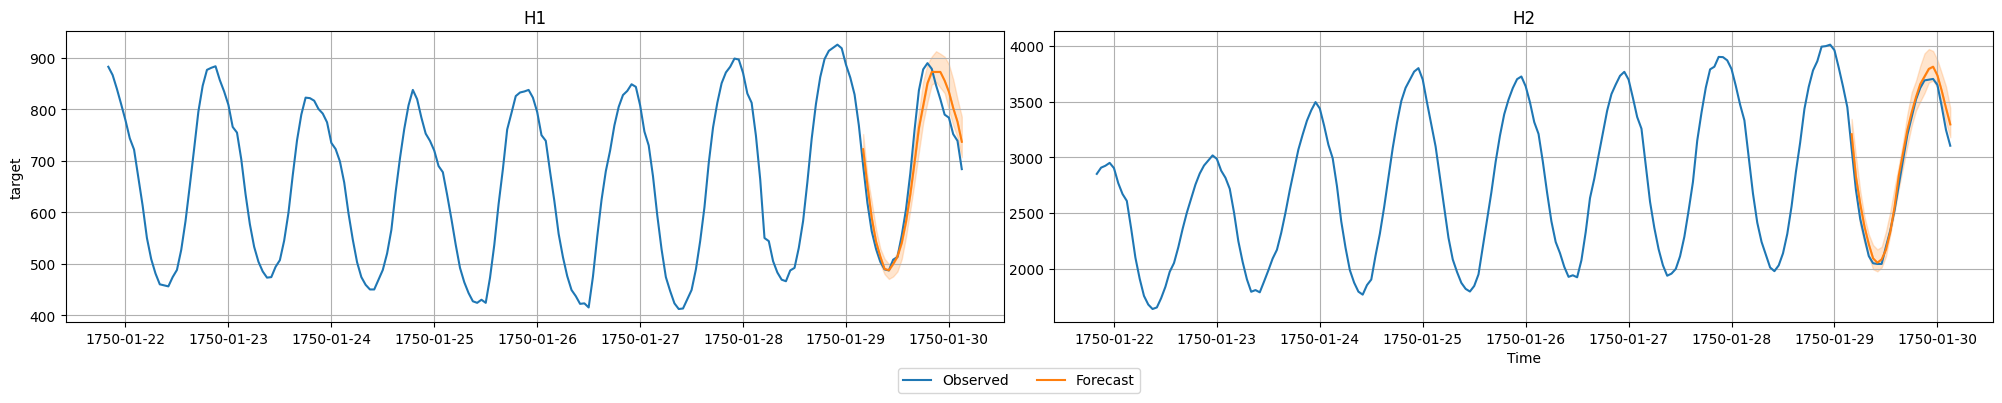

In [5]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=["H1", "H2"],
    max_history_length=200,
);

## Configuring for Performance

Looks good! As with all large deep learning models, however, some fine-grained control of inference parameters can be needed to both optimize the speed and avoid out-of-memory issues on specific hardware. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [ ]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 2min 4s, sys: 42.4 s, total: 2min 47s
Wall time: 11.2 s


Above, we used the following configuration options for the `TimeSeriesPredictor`:
- we set `skip_model_selection=True` to skip running backtests during `fit`, as we will only consider a single model.
- in the `hyperparameters` for the Chronos model,
    - `model_path` allows us to change the model size or select different pretrained weights. This parameter can be a model string like `tiny` or `base`, a Hugging Face path like `amazon/chronos-t5-mini`, or a path to a local folder with custom weights.
    - `batch_size` configures the number of time series for which predictions are generated in parallel.
    - `device` instructs Chronos to run the model on CPU.

As we see, inference speed is slower on the CPU compared to the GPU, taking about 400ms per time series.
To overcome this limitation, AutoGluon implementation of Chronos supports several deep learning compilers that can optimize model performance on CPUs.

For example, we can set `optimization_strategy="openvino"` to use the [OpenVINO](https://github.com/openvinotoolkit/openvino) compiler for Intel CPUs to speed up Chronos inference. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion.

Note that this requires installing the optional OpenVINO dependency for AG-TS.

In [ ]:
!pip install -q "autogluon.timeseries[chronos-openvino]"

To speed up the inference even further, we can `persist` the model after calling `fit`. The `TimeSeriesPredictor.persist` method tells AutoGluon to keep the Chronos model in device memory for fast, on-demand inference instead of loading the model from disk each time.

In [ ]:
%%capture
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)
predictor.persist()

In [ ]:
%%time
predictions = predictor.predict(train_data)

CPU times: user 1min 8s, sys: 9.19 s, total: 1min 17s
Wall time: 2.9 s


That reduced the inference time by ~3x!

We could have also used the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).

## FAQ


#### How accurate is Chronos?

In several independent evaluations we found Chronos to be effective in zero-shot forecasting.
The accuracy of Chronos-large often exceeds statistical baseline models, and is often comparable to deep learning
models such as `TemporalFusionTransformer` or `PatchTST`.

#### What hardware do larger Chronos models require?

We tested Chronos on AWS `g5.2xlarge` and `p3.2xlarge` instances that feature NVIDIA A10G and V100 GPUs, with at least 16GiB of GPU memory and 32GiB of main memory.

#### Can I fine-tune Chronos?

The current iteration of Chronos on AutoGluon does not support fine tuning, although we will provide this functionality in later versions of AutoGluon.

#### Does Chronos work with covariates or features?

The current iteration of Chronos does not support covariates or features, however we will provide this functionality in
later versions. In the meanwhile, presets such as `chronos_ensemble` combine Chronos with models that do take advantage of features.

#### Where can I ask specific questions on Chronos?

The AutoGluon team are among the core developers of Chronos. So you can ask Chronos-related questions on AutoGluon channels such
as the Discord [server](https://discord.gg/wjUmjqAc2N), or [GitHub](https://github.com/autogluon/autogluon). You can also join
the discussion on the Chronos GitHub [page](https://github.com/amazon-science/chronos-forecasting/discussions).